# How to Open Machine Learning Input Products

For each faint (g>22) detectid in the HDR3 + HDR4 line emission database we have generated 100 pixel (200 Angstrom) by 9 pixel fiber cutouts of the weighted sum of all fibers used to measured the extracton as well as cutouts of the four brightest fibers contributing to the flux. We also include the 1D spectrum (this is the same product included in the Spectra table for the detect_hdrX.h5 file) and a 30 arcsec x 30 arcsec cutout of HSC r-band imaging for the detection in available. The latest version here also includes a pseudo continuum-subtracted narrowband image at emission line wavelength.

In [1]:
import tables as tb
import numpy as np
import os.path as op

from astropy.table import Table, join, unique
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval

from hetdex_api.config import HDRconfig


In [2]:
from IPython.display import display, Javascript


In [3]:
%matplotlib inline

In [4]:
config = HDRconfig('hdr4')

First we show some examples of opening the source catalog or line labels if interested. This is not necessary to access the ML products. Uncomment these cell blocks if you want to access these.

In [5]:
### Enter the catalog version - Run this if you want to open the catalog

version = '4.0.0'

config = HDRconfig()
catfile = op.join(config.hdr_dir['hdr4'], 'catalogs', 'source_catalog_' + version + '.fits')
source_table = Table.read(catfile)

print('Source catalog was found at {}'.format(catfile))

Source catalog was found at /scratch/projects/hetdex/hdr4/catalogs/source_catalog_4.0.0.fits


In [6]:
### Get Line labels - Run this if you want to see labels generated by RAIC

labelfile = op.join( config.hdr_dir['hdr4'], 'catalogs','ml','line_labels_07-11-23.csv')
line_labels = Table.read(labelfile, format='ascii')

#### get detectid into a column

dets = []

for row in line_labels:
    dets.append( int( row['FileName'].split('/')[-1].split('.jpg')[0]))
#### RAIC includes detection as part of its classifying, we can select on region if desired. There can be multiple labels for an image. It can be assigned two different label types and it can also be given multiple of the same label for different regions of the line image.

print(Table( np.unique( line_labels['Category'], return_counts=True)))

  Category   col1
------------ ----
    extended 3940
      meteor 3018
point_source 2105
      streak 2247


This file has the summed fiber cutout image and invidual fiber cutout images as well as HSC r-band imaging if available. We also include the 1D extracted spectrum of the detection and the line image

In [7]:
## Pytables and hetdex_api.config provide an easy interface to the ML products

mlfile = op.join( config.hdr_dir['hdr4'], 'catalogs','ml','detect_ml_4.0.0.h5')
fileh = tb.open_file(mlfile, 'r') 

print('ML data product file is found at {}'.format(mlfile))

ML data product file is found at /scratch/projects/hetdex/hdr4/catalogs/ml/detect_ml_4.0.0.h5


Here is the hierarchical structure:

In [8]:
fileh

File(filename=/scratch/projects/hetdex/hdr4/catalogs/ml/detect_ml_4.0.0.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/FiberImages (Table(2461778,)) 'Fiber Cutout Images'
  description := {
  "detectid": Int64Col(shape=(), dflt=0, pos=0),
  "im_wave": Float32Col(shape=(100,), dflt=0.0, pos=1),
  "im_sum": Float32Col(shape=(9, 100), dflt=0.0, pos=2),
  "im_array": Float32Col(shape=(4, 9, 100), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (56,)
  autoindex := True
  colindexes := {
    "detectid": Index(9, fullshuffle, zlib(1)).is_csi=True}
/LineImages (Table(2461778,)) 'Line Emission Map Image'
  description := {
  "detectid": Int64Col(shape=(), dflt=0, pos=0),
  "apcor": Float32Col(shape=(), dflt=0.0, pos=1),
  "bkg_stddev": Float32Col(shape=(), dflt=0.0, pos=2),
  "delta_dec": Float32Col(shape=(80, 80), dflt=0.0, pos=3),
  "delta_ra": Float32Col(shape=(8

### Open the 2D Summed Fiber Image

Because we have over 1 million detections in each table and each table contains several 2D arrays, the best way to navigate the file is by detectid. We have indexed all three tables based on the detectid so it is fast to query. But we do suggest you do it one by one. Please do not make copies of every component of this file on TACC anywhere on /work. Ideally you should learn to use the h5 files, otherwise pick smaller subsets of detections to work with.

In [9]:
detectid_obj = 4025008681

In [10]:
obj_data = fileh.root.FiberImages.read_where('detectid == detectid_obj')[0]

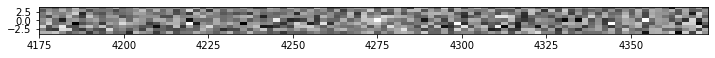

In [11]:
height=9 # in pixels
detectid = obj_data['detectid']
wave = obj_data['im_wave']
im_sum = obj_data['im_sum'] # this is the 2D summed image, 1st dim is height in fiber dims, 2nd dim is wave dim
im_array = obj_data['im_array'] # this is the 4 brightest fibers, 1st dim is fibers, 2nd dim is fiber dims, 3rd is wavelength
zscale = ZScaleInterval(contrast=0.5,krej=2.5)
vmin, vmax = zscale.get_limits(values=im_sum)
plt.figure(figsize=(12,5))
plt.imshow(im_sum,vmin=vmin, vmax=vmax,extent=[wave[0], wave[-1], -int(height/2.), int(height/2.)], origin="lower",cmap=plt.get_cmap('gray'),interpolation="none")
plt.show()

### Get Single Fiber cutouts for the four brightest fibers:

The 'im_array' column consists of fiber cutouts of the 4 brightest fibers

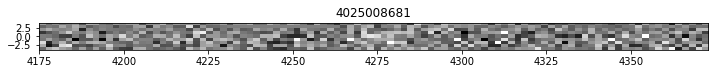

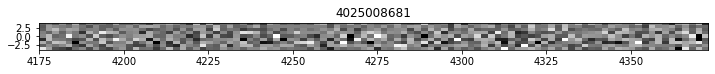

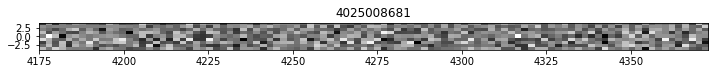

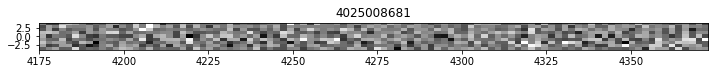

In [12]:
# plot each fiber for 4th object in example table
height=9

detectid = obj_data['detectid']
wave = obj_data['im_wave']
im_sum = obj_data['im_sum'] # this is the 2D summed image, 1st dim is height in fiber dims, 2nd dim is wave dim
im_array = obj_data['im_array'] # this is the 4 brightest fibers, 1st dim is fibers, 2nd dim is fiber dims, 3rd is wavelength
for im_i in np.arange(0,4):
    zscale = ZScaleInterval(contrast=0.5,krej=2.5)
    vmin, vmax = zscale.get_limits(values=im_array[im_i])
    plt.figure(figsize=(12,4))
    plt.title(str(detectid))
    plt.imshow(im_array[im_i],vmin=vmin, vmax=vmax,extent=[wave[0], wave[-1], -int(height/2.), int(height/2.)], origin="lower",cmap=plt.get_cmap('gray'),interpolation="none")
    plt.show()

Get the HSC 'r' band image if available

In [13]:
phot_image_table = Table(fileh.root.PhotImages.read_where('detectid == detectid_obj'))

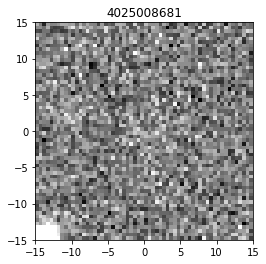

In [14]:
#Loop over the images
height=9
for row in phot_image_table:
    detectid = row['detectid']
    im_phot = row['im_phot'] # this is the r-band image
    zscale = ZScaleInterval(contrast=0.5,krej=2.5)
    vmin, vmax = zscale.get_limits(values=im_phot)
    plt.figure()
    plt.title(str(detectid))
    plt.imshow(im_phot,vmin=vmin, vmax=vmax,extent=[-15, 15, -15, 15], origin="lower",cmap=plt.get_cmap('gray'),interpolation="none")
    plt.show()

### Get the Detection Spectrum

The 1D aperture Summed Spectrum is also contained in this file

In [15]:
spec_table = Table(fileh.root.Spec1D.read_where('detectid == detectid_obj'))

(4174.8212890625, 4374.8212890625)

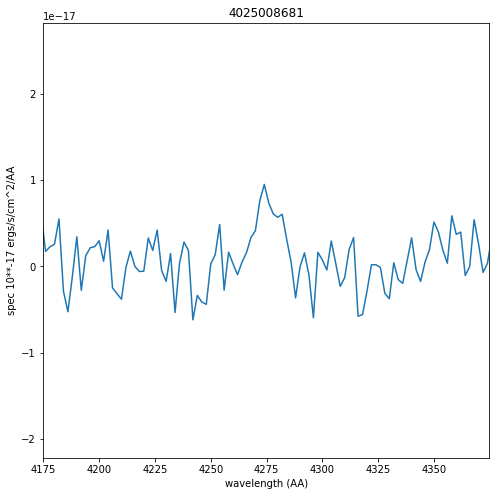

In [16]:
wave_rect = 2.0 * np.arange(1036) + 3470.0
plt.figure(figsize=(8,8))
plt.plot(wave_rect, spec_table['spec1D'][0]*10**-17 * u.erg / (u.cm ** 2 * u.s * u.AA))
plt.xlabel('wavelength (AA)')
plt.ylabel('spec 10**-17 ergs/s/cm^2/AA')
plt.title(detectid_obj)
plt.xlim(wave[50]-100,wave[50]+100)

### Accessing the Line Flux Map images

In [17]:
from astropy import wcs
from astropy.visualization import ZScaleInterval
from astropy.stats import sigma_clipped_stats

In [18]:
# This function converts the row data from the H5 file into an HDU FITS standard
def get_hdu(detectid_obj):
    im_data = fileh.root.LineImages.read_where('detectid == detectid_obj')[0]
    header = fits.Header.fromstring(im_data['header'])
    hdu = fits.PrimaryHDU(im_data['line_image'], header=header)
    hdu_error = fits.ImageHDU(im_data['line_image_err'], header=header)
    hdu_x = fits.ImageHDU(im_data['delta_ra'], header=header)
    hdu_y = fits.ImageHDU(im_data['delta_dec'], header=header)
    return fits.HDUList([hdu, hdu_error, hdu_x, hdu_y])

Text(0.5, 1.0, '4025008681')

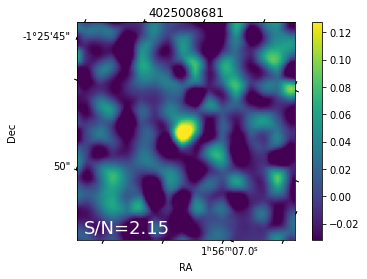

In [19]:
hdu = get_hdu(detectid_obj)

sn_im = fileh.root.LineImages.read_where('detectid == detectid_obj')[0]['sn_im']

im = hdu[0].data
error = hdu[1].data
w = wcs.WCS(hdu[0].header)

mean_sigclip, median_sigclip, stddev_sigclip = sigma_clipped_stats(im)

plt.subplot(111, projection=w)
plt.imshow(im, vmin= -1 * stddev_sigclip, vmax=4 * stddev_sigclip)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.colorbar()

plt.text(
    2,
    2,
    "S/N={:3.2f}".format(sn_im),
    size=18,
    color="w",
)
plt.title(str(detectid_obj))

## PLEASE CLOSE THE H5 FILE WHEN DONE

When done with an h5 file you should close it:

In [20]:
fileh.close()